
# Balanced neuron example

This script simulates a neuron driven by an excitatory and an
inhibitory population of neurons firing Poisson spike trains. The aim
is to find a firing rate for the inhibitory population that will make
the neuron fire at the same rate as the excitatory population.

Optimization is performed using the ``bisection`` method from Scipy,
simulating the network repeatedly.

This example is also shown in the article [1]_

## References

.. [1] Eppler JM, Helias M, Mulller E, Diesmann M, Gewaltig MO (2009). PyNEST: A convenient interface to the NEST
       simulator, Front. Neuroinform.
       http://dx.doi.org/10.3389/neuro.11.012.2008


First, we import all necessary modules for simulation, analysis and
plotting. Scipy should be imported before nest.



In [1]:
import matplotlib.pyplot as plt
import nest
import nest.voltage_trace
from scipy.optimize import bisect

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Mar 14 2024 22:33:10

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



Additionally, we set the verbosity using ``set_verbosity`` to
suppress info messages.



In [2]:
nest.set_verbosity("M_WARNING")
nest.ResetKernel()

Second, the simulation parameters are assigned to variables.



In [3]:
t_sim = 25000.0  # how long we simulate
n_ex = 16000  # size of the excitatory population
n_in = 4000  # size of the inhibitory population
r_ex = 5.0  # mean rate of the excitatory population
r_in = 20.5  # initial rate of the inhibitory population
epsc = 45.0  # peak amplitude of excitatory synaptic currents
ipsc = -45.0  # peak amplitude of inhibitory synaptic currents
d = 1.0  # synaptic delay
lower = 15.0  # lower bound of the search interval
upper = 25.0  # upper bound of the search interval
prec = 0.01  # how close need the excitatory rates be

Third, the nodes are created using ``Create``. We store the returned
handles in variables for later reference.



In [4]:
neuron = nest.Create("iaf_psc_alpha")
noise = nest.Create("poisson_generator", 2)
voltmeter = nest.Create("voltmeter")
spikerecorder = nest.Create("spike_recorder")

Fourth, the ``poisson_generator`` (`noise`) is configured.
Note that we need not set parameters for the neuron, the spike recorder, and
the voltmeter, since they have satisfactory defaults.



In [5]:
noise.rate = [n_ex * r_ex, n_in * r_in]

Fifth, the ``iaf_psc_alpha`` is connected to the ``spike_recorder`` and the
``voltmeter``, as are the two Poisson generators to the neuron. The command
``Connect`` has different variants. Plain `Connect` just takes the handles of
pre- and postsynaptic nodes and uses the default values for weight and
delay. It can also be called with a list of weights, as in the connection
of the noise below.
Note that the connection direction for the ``voltmeter`` is reversed compared
to the ``spike_recorder``, because it observes the neuron instead of
receiving events from it. Thus, ``Connect`` reflects the direction of signal
flow in the simulation kernel rather than the physical process of inserting
an electrode into the neuron. The latter semantics is presently not
available in NEST.



In [6]:
nest.Connect(neuron, spikerecorder)
nest.Connect(voltmeter, neuron)
nest.Connect(noise, neuron, syn_spec={"weight": [[epsc, ipsc]], "delay": 1.0})

To determine the optimal rate of the neurons in the inhibitory population,
the network is simulated several times for different values of the
inhibitory rate while measuring the rate of the target neuron. This is done
by calling ``Simulate`` until the rate of the target neuron matches the rate
of the neurons in the excitatory population with a certain accuracy. The
algorithm is implemented in two steps:

First, the function ``output_rate`` is defined to measure the firing rate
of the target neuron for a given rate of the inhibitory neurons.



In [7]:
def output_rate(guess):
    print("Inhibitory rate estimate: %5.2f Hz" % guess)
    rate = float(abs(n_in * guess))
    noise[1].rate = rate
    spikerecorder.n_events = 0
    nest.Simulate(t_sim)
    out = spikerecorder.n_events * 1000.0 / t_sim
    print("  -> Neuron rate: %6.2f Hz (goal: %4.2f Hz)" % (out, r_ex))
    return out

The function takes the firing rate of the inhibitory neurons as an
argument. It scales the rate with the size of the inhibitory population and
configures the inhibitory Poisson generator (`noise[1]`) accordingly.
Then, the spike counter of the ``spike_recorder`` is reset to zero. The
network is simulated using ``Simulate``, which takes the desired simulation
time in milliseconds and advances the network state by this amount of time.
During simulation, the ``spike_recorder`` counts the spikes of the target
neuron and the total number is read out at the end of the simulation
period. The return value of ``output_rate()`` is the firing rate of the
target neuron in Hz.

Second, the scipy function ``bisect`` is used to determine the optimal
firing rate of the neurons of the inhibitory population.



In [8]:
in_rate = bisect(lambda x: output_rate(x) - r_ex, lower, upper, xtol=prec)
print("Optimal rate for the inhibitory population: %.2f Hz" % in_rate)

Inhibitory rate estimate: 15.00 Hz
  -> Neuron rate: 347.56 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 25.00 Hz
  -> Neuron rate:   0.04 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 20.00 Hz
  -> Neuron rate:  34.88 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 22.50 Hz
  -> Neuron rate:   0.00 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 21.25 Hz
  -> Neuron rate:   0.84 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 20.62 Hz
  -> Neuron rate:   7.40 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 20.94 Hz
  -> Neuron rate:   3.08 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 20.78 Hz
  -> Neuron rate:   4.40 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 20.70 Hz
  -> Neuron rate:   6.32 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 20.74 Hz
  -> Neuron rate:   4.88 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 20.72 Hz
  -> Neuron rate:   5.96 Hz (goal: 5.00 Hz)
Inhibitory rate estimate: 20.73 Hz
  -> Neuron rate:   5.52 Hz (goal: 5.00 Hz)
Optimal rate for the inhibitory population: 20.73 Hz

The function ``bisect`` takes four arguments: first a function whose
zero crossing is to be determined. Here, the firing rate of the target
neuron should equal the firing rate of the neurons of the excitatory
population. Thus we define an anonymous function (using `lambda`) that
returns the difference between the actual rate of the target neuron and the
rate of the excitatory Poisson generator, given a rate for the inhibitory
neurons. The next two arguments are the lower and upper bound of the
interval in which to search for the zero crossing. The fourth argument of
``bisect`` is the desired relative precision of the zero crossing.

Finally, we plot the target neuron's membrane potential as a function of
time.



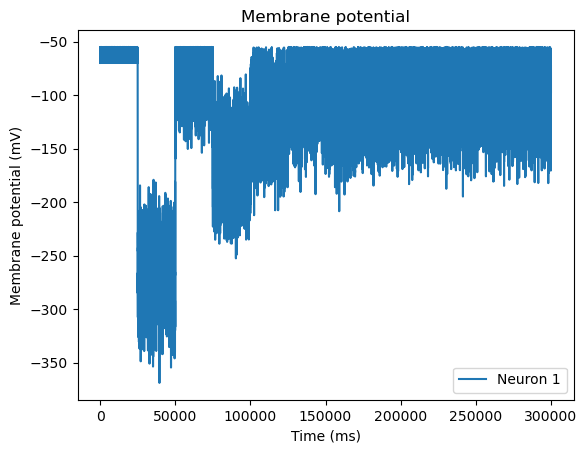

In [9]:
nest.voltage_trace.from_device(voltmeter)
plt.show()